# AMG emphasis factor analysis

In this notebook, we compute various impacts due to increasing flux through multiple AMG-hijacked reactions. We use the AMG emphasis factor approach described in the manuscript that accompanies this repository.

In [1]:
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graph_utils as gu
import networkx as nx
import json
from amg_utils import amg_impact_by_parsimony
from plotting_utils import draw_graph

In [2]:
masses = json.loads(open("model_files/masses.json").read())
manual_relabels = json.loads(open("model_files/subsystem_alias.json").read())
amgs = json.loads(open("model_files/amg_reactions.json").read())
amg_gene_names = json.loads(open("model_files/amg_gene_map.json").read())
amg_rxn_names = {k: f"{v}: {k}" for k, v in amg_gene_names.items()}

In [3]:
model = cobra.io.read_sbml_model("./model_files/ProchlorococcusMED4+PHM2v1.xml")

In [4]:
no_mass_masses = {k.id: 1 for k in model.metabolites}

In [5]:
def nearest_ind(df, v):
    return min(range(len(df.index)), key=lambda x: abs(df.index[x] - v))


def flux_at_val(df, v):
    return df.iloc[nearest_ind(df, v), 0].fluxes

## Set nutrient uptake limits

We use FVA to find optimal nutrient uptake rates for host and phage. We use these to set generous upper bounds on nutrient uptake so as to mitigate flux boundary effects. The values are stored (statically) in `amg_utils.py`.

In [6]:
with model as host_model:
    h_fva = cobra.flux_analysis.flux_variability_analysis(
        host_model,
        [
            host_model.reactions.AmmoniaEX,
            host_model.reactions.FAKEOrthophosphateEX,
            host_model.reactions.HCO3EXcar,
            host_model.reactions.LightEX,
        ],
    )
with model as phage_model:
    phage_model.objective = phage_model.reactions.PHM2_prodrxn_VN.flux_expression
    p_fva = cobra.flux_analysis.flux_variability_analysis(
        phage_model,
        [
            phage_model.reactions.AmmoniaEX,
            phage_model.reactions.FAKEOrthophosphateEX,
            phage_model.reactions.HCO3EXcar,
            phage_model.reactions.LightEX,
        ],
    )

print("Host-optimal")
print(h_fva)
print()
print("Phage-optimal")
print(p_fva)

Host-optimal
                          minimum    maximum
AmmoniaEX               -0.864117  -0.855149
FAKEOrthophosphateEX    -0.033099  -0.033099
HCO3EXcar            -1000.000000  -5.341752
LightEX              -1000.000000 -72.510110

Phage-optimal
                          minimum    maximum
AmmoniaEX               -1.607938  -1.607938
FAKEOrthophosphateEX    -0.183978  -0.183978
HCO3EXcar            -1000.000000  -4.913298
LightEX              -1000.000000 -56.319861


In [7]:
# (from amg_utils.py)
# BOUND_FACTOR = 5
# N_LIMIT = -0.86 * BOUND_FACTOR
# P_LIMIT = -0.18 * BOUND_FACTOR
# C_LIMIT = -5.4 * BOUND_FACTOR
# L_LIMIT = -73 * BOUND_FACTOR

## Apply the emphasis factor approach

See manuscript for details.

In [70]:
baselines = []
infecteds = []
diffs = []
penalties = np.linspace(0, 10, 111)
# penalties = np.linspace(0, 10, 21) # useful for quick testing
baseline = amg_impact_by_parsimony(
    model,
    amgs,
    new_amg_penalty=0,
)
for amg_penalty in penalties:
    infected = amg_impact_by_parsimony(
        model,
        amgs,
        new_amg_penalty=-amg_penalty,
    )
    diff = infected.fluxes - baseline.fluxes
    baselines.append(baseline)
    infecteds.append(infected)
    diffs.append(diff)

baselines = pd.DataFrame(baselines, index=penalties)
infecteds = pd.DataFrame(infecteds, index=penalties)

absdiffs = pd.DataFrame(
    [
        infected.fluxes.abs() - baseline.fluxes.abs()
        for infected, baseline in zip(
            infecteds.values.flatten(), baselines.values.flatten()
        )
    ],
    index=penalties,
)

diffs = pd.DataFrame(diffs, index=penalties)
diffs

,R01055,R00546,R05605,R00346,R00355,R00357,R00369,R00485,R00489,R00768,...,R05681,R04439,R02097,Trans_S_Malate,S_MalateEX,R01078,Trans_H2O2,H2O2EX,R02036,PHM2_prodrxn_VN
0.000000,0.0,0.0,-1.376677e-13,0.0,-4.829470e-14,0.0,1.710437e-15,-3.582204e-16,-6.881973e-17,-2.550044e-16,...,0.0,3.094747e-15,0.0,0.0,0.0,0.0,-3.197963e-15,-3.197963e-15,-1.376677e-13,0.0
0.090909,0.0,0.0,-1.374456e-13,0.0,-4.829470e-14,0.0,1.710437e-15,-3.582204e-16,-6.881973e-17,-2.550044e-16,...,0.0,3.094747e-15,0.0,0.0,0.0,0.0,-3.197963e-15,-3.197963e-15,-1.375566e-13,0.0
0.181818,0.0,0.0,-1.376677e-13,0.0,-4.829470e-14,0.0,1.710437e-15,-3.582204e-16,-6.881973e-17,-2.550044e-16,...,0.0,3.094747e-15,0.0,0.0,0.0,0.0,-3.197963e-15,-3.197963e-15,-1.376677e-13,0.0
0.272727,0.0,0.0,-1.374456e-13,0.0,-4.829470e-14,0.0,1.710437e-15,-3.582204e-16,-6.881973e-17,-2.550044e-16,...,0.0,3.094747e-15,0.0,0.0,0.0,0.0,-3.197963e-15,-3.197963e-15,-1.375566e-13,0.0
0.363636,0.0,0.0,-1.376677e-13,0.0,-4.829470e-14,0.0,1.710437e-15,-3.582204e-16,-6.881973e-17,-2.550044e-16,...,0.0,3.094747e-15,0.0,0.0,0.0,0.0,-3.197963e-15,-3.197963e-15,-1.376677e-13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.636364,0.0,0.0,-1.442180e-13,0.0,3.580469e-15,0.0,1.932482e-15,-4.041906e-16,-6.881973e-17,-2.879641e-16,...,0.0,3.469447e-15,0.0,0.0,0.0,0.0,-7.180020e-15,-7.180020e-15,-1.442180e-13,0.0
9.727273,0.0,0.0,-1.442180e-13,0.0,3.580469e-15,0.0,1.932482e-15,-4.041906e-16,-6.881973e-17,-2.879641e-16,...,0.0,3.469447e-15,0.0,0.0,0.0,0.0,-7.180020e-15,-7.180020e-15,-1.442180e-13,0.0
9.818182,0.0,0.0,-1.442180e-13,0.0,3.580469e-15,0.0,1.932482e-15,-4.041906e-16,-6.881973e-17,-2.879641e-16,...,0.0,3.469447e-15,0.0,0.0,0.0,0.0,-7.180020e-15,-7.180020e-15,-1.442180e-13,0.0
9.909091,0.0,0.0,-1.442180e-13,0.0,3.580469e-15,0.0,1.932482e-15,-4.041906e-16,-6.881973e-17,-2.879641e-16,...,0.0,3.469447e-15,0.0,0.0,0.0,0.0,-7.180020e-15,-7.180020e-15,-1.442180e-13,0.0


## Plot results
We plot the 20 reactions that are most affected by increasing the AMG emphasis factor. We also plot the response of the AMG-hijacked reactions to changes in the emphasis factor. AMG-hijacked reactions that are not shown are unaffected within the range of emphasis factor tested here.

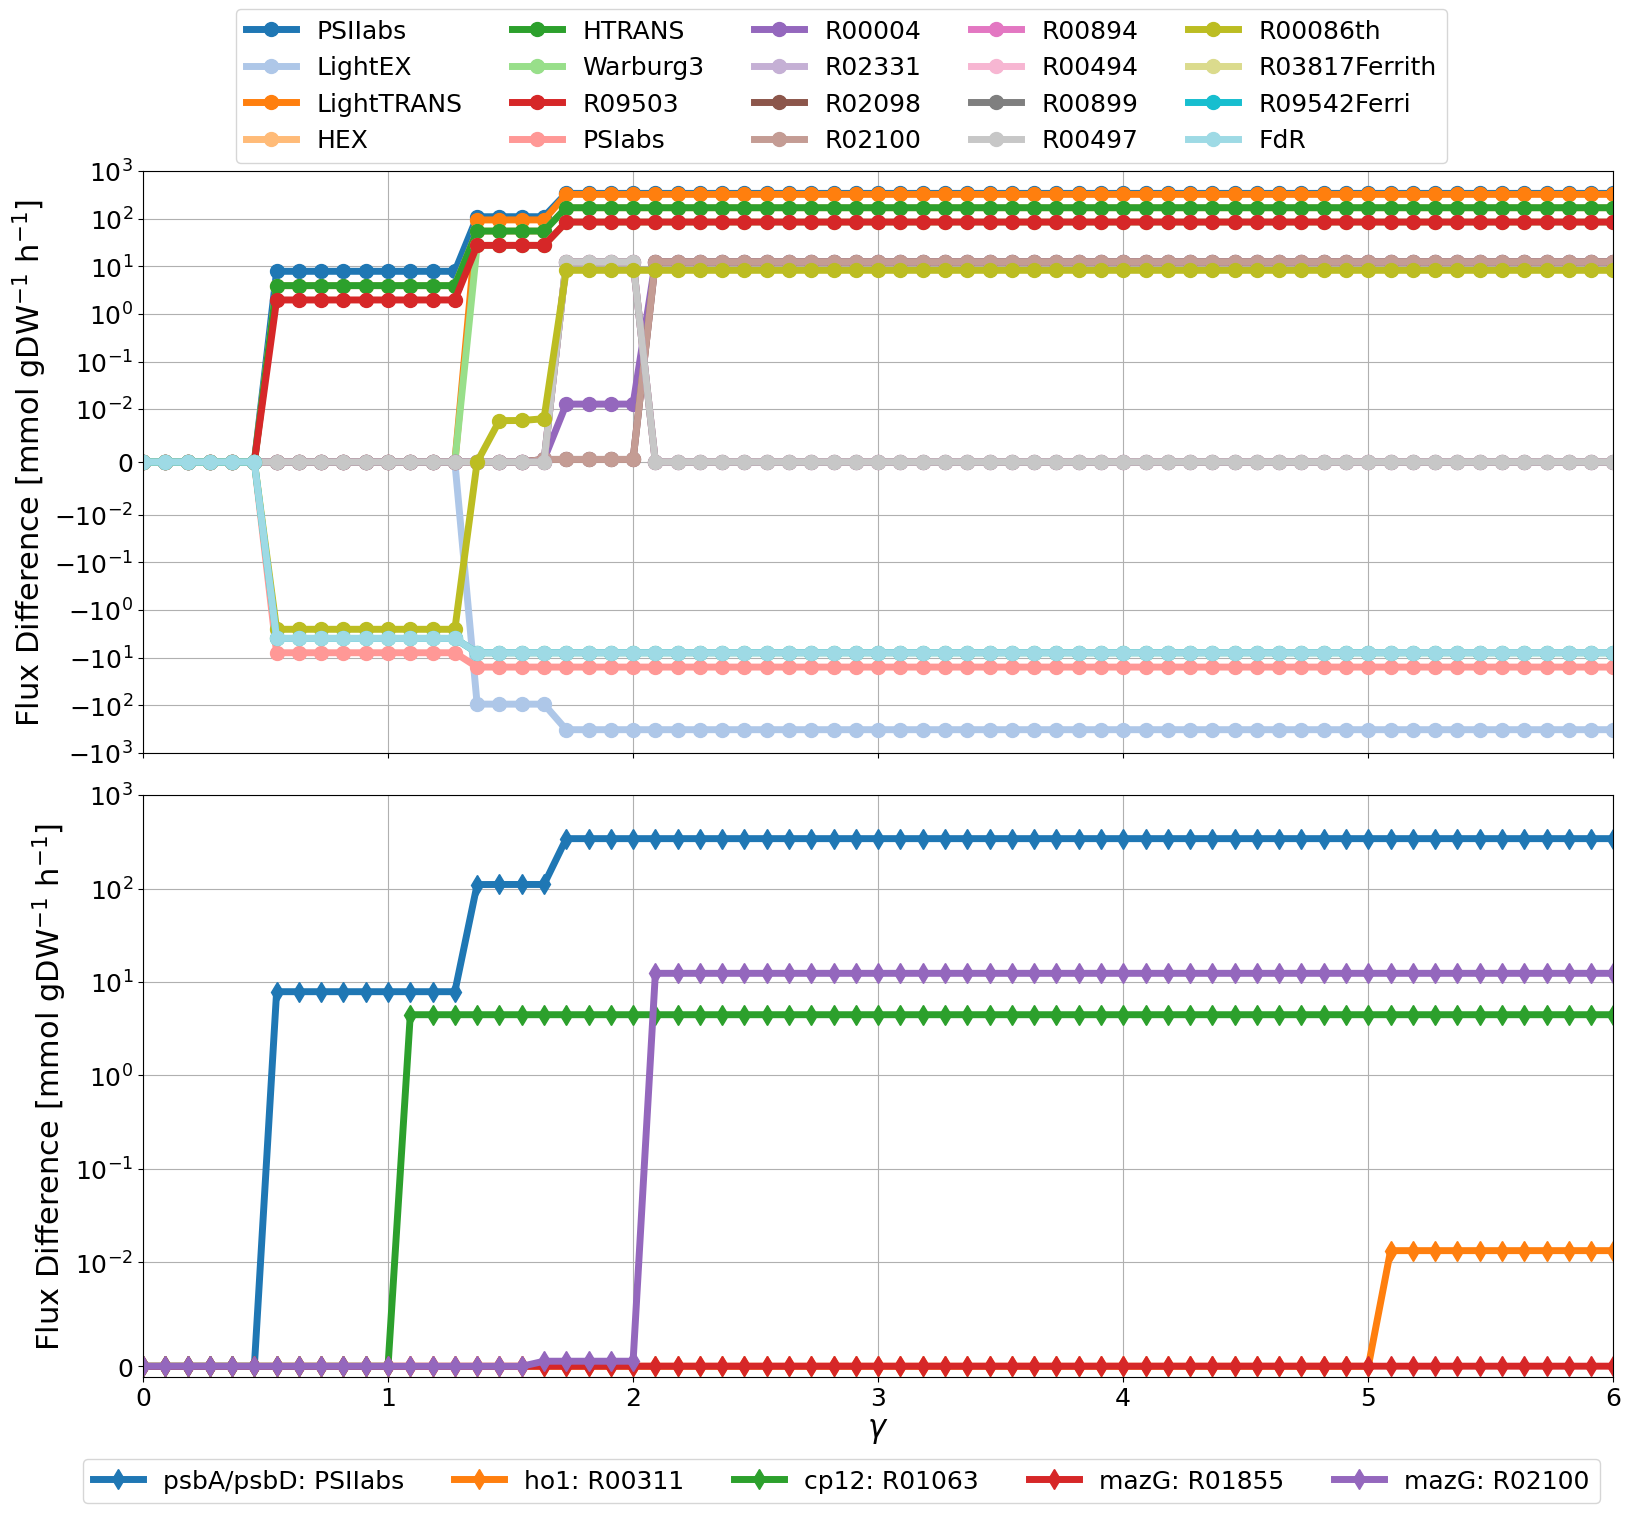

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(17, 15), sharex=True)
top10 = diffs.abs().max(axis=0).sort_values(ascending=False)[0:20].index
next10 = diffs.abs().max(axis=0).sort_values(ascending=False)[10:20].index
diffs[top10].plot(
    ax=axs[0],
    marker="o",
    # fillstyle="none",
    linewidth=5,
    markersize=10,
    colormap="tab20",
)
# diffs[next10].plot(
#     ax=axs[0],
#     marker="x",
#     fillstyle="none",
#     linewidth=5,
#     markersize=10,
# )

axs[0].set_yscale("symlog", linthresh=1e-2)
axs[0].tick_params(labelsize=18)
axs[0].legend(ncols=5, loc="upper center", bbox_to_anchor=(0.475, 1.3), fontsize=18)
# axs[0].set_xlim(0, 6)
axs[0].set_ylim(-1e3, 1e3)
axs[0].set_xlabel(r"$\gamma$", fontsize=22)
axs[0].set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=22)
axs[0].grid(True, which="both")
# plt.show()
(
    diffs[[col for col in amgs if diffs[col].abs().max() > 1e-7]]
    # * np.random.uniform(0.9, 1.1, (len(diffs), 10)) # uncomment to add noise to check for overlap
).plot(
    ax=axs[1],
    marker="d",
    # fillstyle="none",
    linewidth=5,
    markersize=10,
)
axs[1].set_yscale("symlog", linthresh=1e-2)
axs[1].tick_params(labelsize=18)

_, lab = axs[1].get_legend_handles_labels()
axs[1].legend(
    [amg_rxn_names[g] for g in lab],
    ncols=5,
    loc="upper center",
    bbox_to_anchor=(0.475, -0.12),
    fontsize=18,
)
axs[1].set_xlim(0, 6)
axs[1].set_ylim(-1e-3, 1e3)
axs[1].set_xlabel(r"$\gamma$", fontsize=22)
axs[1].set_ylabel(r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]", fontsize=22)
axs[1].grid(True, which="both")
fig.tight_layout()
plt.show()

## Plot mass flux graphs

We examine the mass flux between metabolic subsystems using methods defined in `graph_utils.py`. Smaller fluxes are not depicted.

We also plot several representative mass flux difference graphs, showing how mass flux between subsystems increases or decreases relative to the baseline at several values of the emphasis factor.

In [10]:
# from typing import Mapping, cast


# class Reaction:
#     id: str
#     name: str
#     subsystem: str
#     upper_bound: float
#     lower_bound: float
#     products: list[cobra.Metabolite]
#     reactants: list[cobra.Metabolite]
#     metabolites: dict[cobra.Metabolite, float]


# Rxns = list[Reaction]


# def subsystem_flux_graph(
#     model: cobra.Model,
#     fluxes: Mapping[str, float],
#     masses: dict[str, float | None],
#     eps: float = 1e-6,
#     eps_flux_conservation: float = 1e-3,
# ) -> nx.DiGraph:
#     gs: nx.DiGraph = nx.DiGraph()

#     subsystems = set(rxn.subsystem for rxn in cast(Rxns, model.reactions))
#     gs.add_nodes_from(subsystems)  # type: ignore

#     met_ss: dict[str, dict[str, float]] = {}
#     for rxn_id, flux in fluxes.items():
#         rxn = cast(Reaction, model.reactions.get_by_id(rxn_id))
#         if abs(flux) <= eps:
#             continue

#         for met, stoic in rxn.metabolites.items():
#             if met.id not in met_ss:
#                 met_ss[met.id] = {}
#             if rxn.subsystem not in met_ss[met.id]:
#                 met_ss[met.id][rxn.subsystem] = flux * stoic
#             else:
#                 met_ss[met.id][rxn.subsystem] += flux * stoic

#     for met_id, ss_dict in met_ss.items():
#         us = [ss for ss, flux in ss_dict.items() if flux > 0]
#         vs = [ss for ss, flux in ss_dict.items() if flux < 0]
#         if met_id in masses:
#             mass = masses[met_id]
#         else:
#             mass = 0
#             print(f"Missing mass for {met_id}")
#         if mass is None or mass == 0:
#             continue
#         assert abs(sum(flux for flux in ss_dict.values())) < eps_flux_conservation
#         rate = sum(flux for flux in ss_dict.values() if flux > 0)
#         if rate == 0:
#             continue
#         for u in us:
#             for v in vs:
#                 w = -ss_dict[u] * ss_dict[v] * mass / rate
#                 if gs.has_edge(u, v):
#                     gs.edges[(u, v)]["weight"] += w
#                 else:
#                     gs.add_edge(u, v, weight=w)  # type: ignore

#     gs.add_node("⌀")  # type: ignore
#     for u in gs.nodes():
#         if u == "⌀":
#             continue
#         od = gs.out_degree(u, weight="weight")
#         id = gs.in_degree(u, weight="weight")
#         assert od >= 0
#         assert id >= 0
#         deficit = od - id  # type: ignore
#         if deficit < 0:
#             gs.add_edge(u, "⌀", weight=-deficit)  # type: ignore
#         elif deficit > 0:
#             gs.add_edge("⌀", u, weight=deficit)  # type: ignore

#     return gs

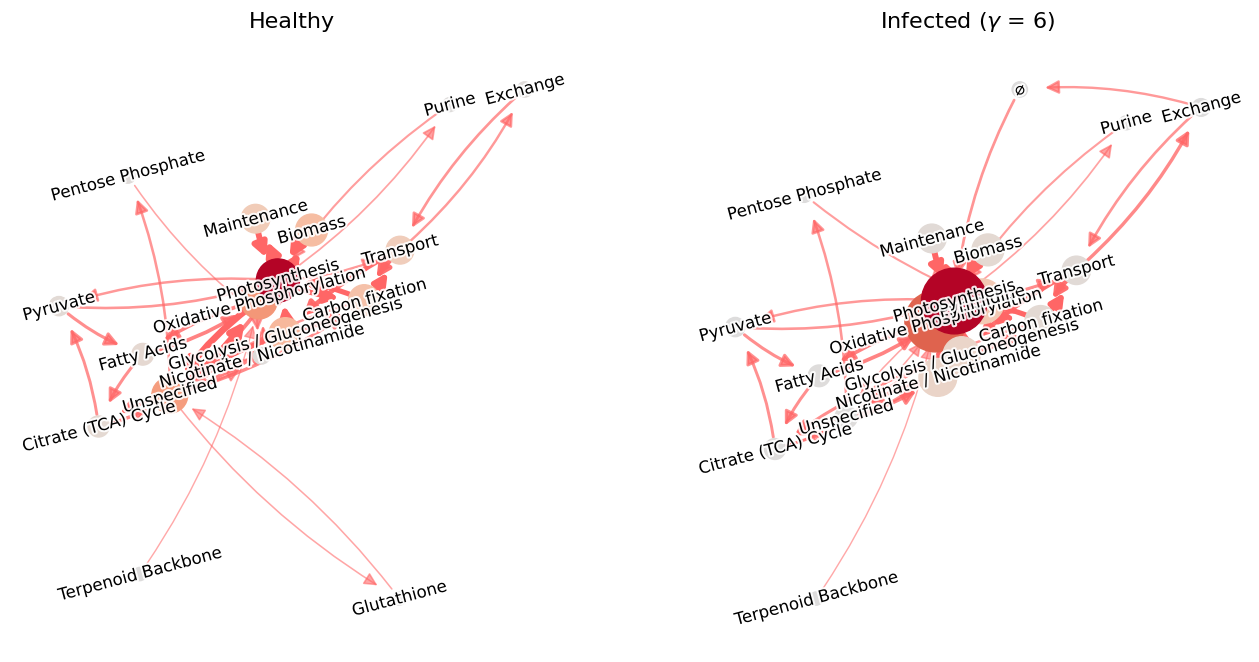

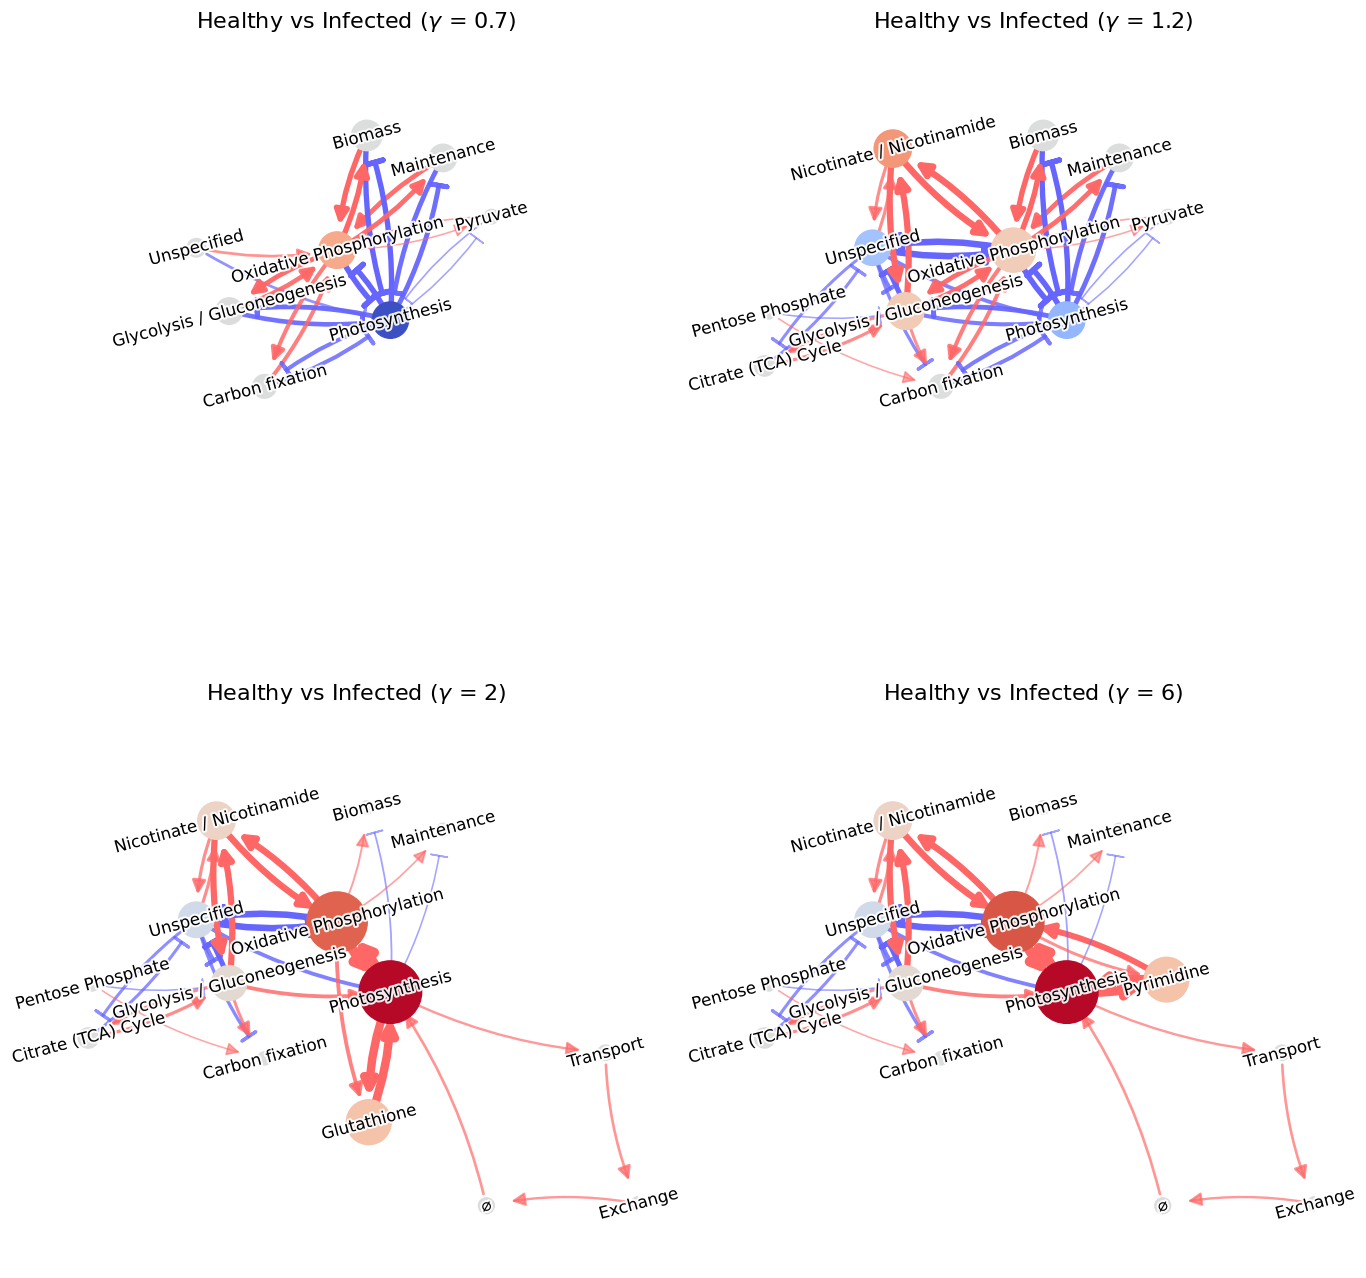

In [116]:
# import importlib
# import plotting_utils

# from plotting_utils import draw_graph

# importlib.reload(plotting_utils)
# from plotting_utils import draw_graph

factor = 6
scale = 30
cut = 50 / scale
g_healthy = gu.subsystem_flux_graph(
    model,
    flux_at_val(baselines, factor),
    masses=masses,
)
g_infected = gu.subsystem_flux_graph(
    model,
    flux_at_val(infecteds, factor),
    masses=masses,
)
pos = nx.layout.fruchterman_reingold_layout(g_infected, seed=0, k=3, iterations=150)
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
draw_graph(
    g_healthy, axs[0], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
draw_graph(
    g_infected, axs[1], manual_relabels=manual_relabels, scale=scale, pos=pos, cut=cut
)
axs[0].set_title("Healthy", fontsize=16)
axs[1].set_title(f"Infected ($\\gamma$ = {factor})", fontsize=16)
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(16, 16))
flist = [0.7, 1.2, 2, 6]

# pos = None
pg = nx.DiGraph()
for r in range(2):
    for ax, factor in zip(axs.flatten(), flist):
        g_healthy = gu.subsystem_flux_graph(
            model,
            flux_at_val(baselines, factor),
            masses=masses,
        )
        g_infected = gu.subsystem_flux_graph(
            model,
            flux_at_val(infecteds, factor),
            masses=masses,
        )

        g_diff = gu.diff_graph(g_infected, g_healthy)

        gs_red = g_diff.edge_subgraph(
            [
                (u, v)
                for u, v, d in g_diff.edges(data=True)
                if np.abs(d["weight"] / scale) > cut
            ]
        )
        if r:
            # if pos is None:
            #     pos = nx.shell_layout(pg)
            # pos = nx.layout.kamada_kawai_layout(pg)
            # if pos is None:
            pos = nx.layout.kamada_kawai_layout(pg, weight=None)
            draw_graph(
                g_diff,
                ax,
                cut=cut,
                manual_relabels=manual_relabels,
                pos=pos,
                scale=scale,
                label_rotation=15,
            )
            ax.set_title(f"Healthy vs Infected ($\\gamma$ = {factor})", fontsize=16)
            ax.set_xlim(-1, 1)
            ax.set_ylim(-1, 1)
        else:
            pg.add_edges_from(gs_red.edges())
plt.show()

In [104]:
plt.cm.coolwarm(5)

(np.float64(0.2526625972549019),
 np.float64(0.3328367876470588),
 np.float64(0.7836650259411765),
 np.float64(1.0))

## Compute subsystem mass flux response

Using the reaction response data computed for each AMG emphasis factor, we construct a mass flux difference graph (such as is plotted above). From this, we compute the net change in flux through each subystem and plot the 20 most affected subsystems.

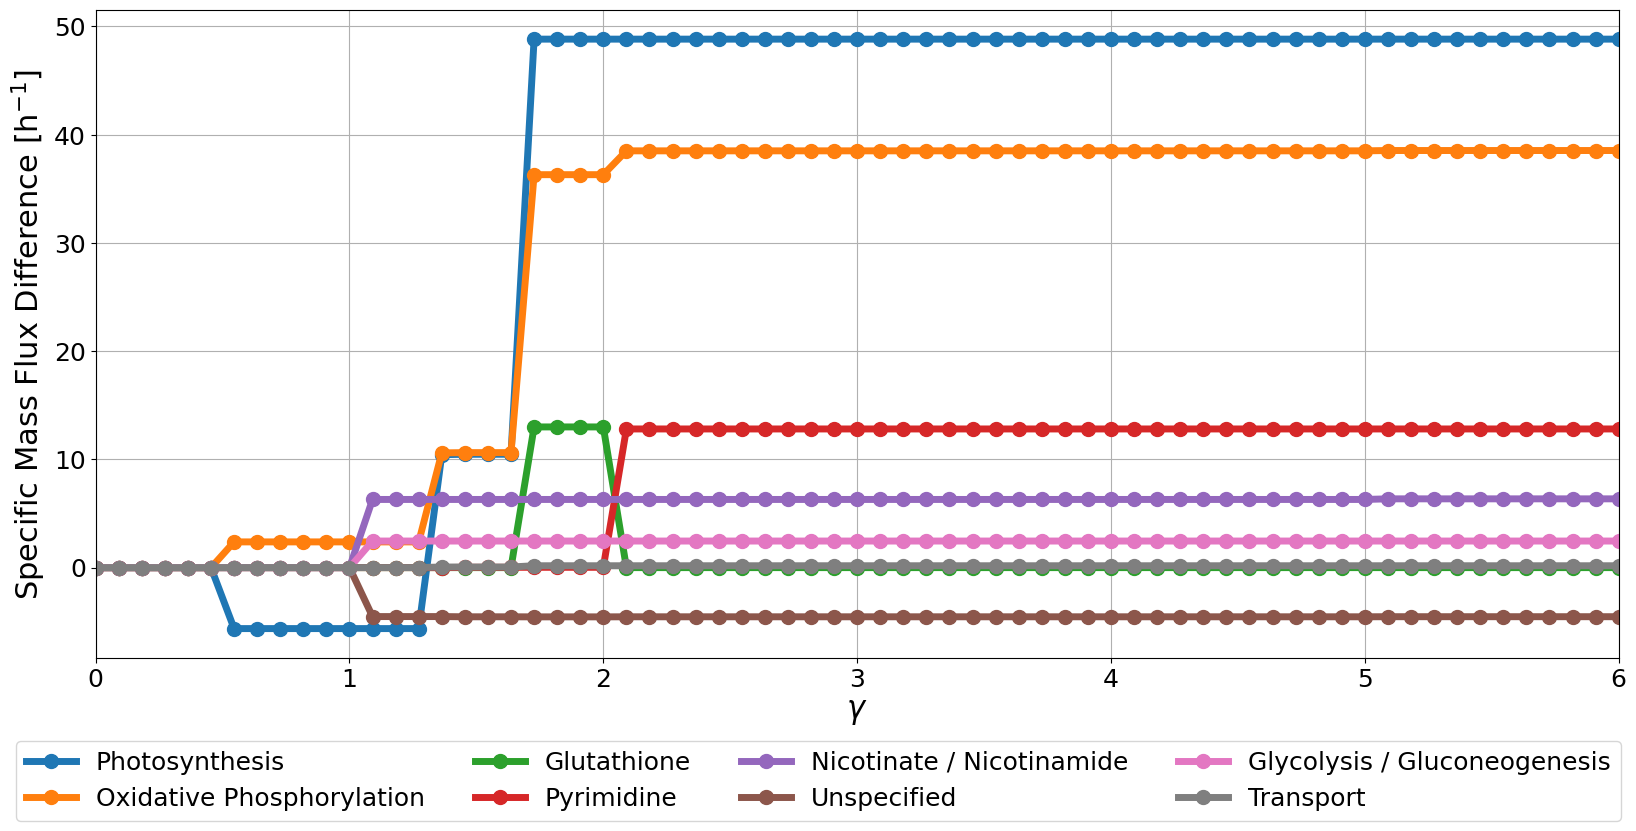

In [12]:
sys_diffs_in = {}
for factor in penalties:
    g_infected = gu.subsystem_flux_graph(
        model,
        flux_at_val(infecteds, factor),
        masses=masses,
    )
    g_healthy = gu.subsystem_flux_graph(
        model,
        flux_at_val(baselines, factor),
        masses=masses,
    )
    g_diff = gu.diff_graph(g_infected, g_healthy)
    if "AMG Emphasis Factor" in sys_diffs_in:
        sys_diffs_in["AMG Emphasis Factor"].append(factor)
    else:
        sys_diffs_in["AMG Emphasis Factor"] = [factor]
    for u in g_diff.nodes():
        deg = g_diff.out_degree(u, weight="weight")
        if u in sys_diffs_in:
            sys_diffs_in[u].append(deg / 1000)
        else:
            sys_diffs_in[u] = [deg / 1000]

sys_diffs_in = pd.DataFrame(sys_diffs_in)
sys_diffs_in.columns = [manual_relabels.get(u, u) for u in sys_diffs_in.columns]
sys_diffs_in.index = sys_diffs_in["AMG Emphasis Factor"]
sys_diffs_in = sys_diffs_in.drop("AMG Emphasis Factor", axis=1)
fig, ax = plt.subplots(1, 1, figsize=(17, 8), sharex=True)
top8sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[0:8].index
top10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[0:10].index
next10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[10:20].index
sys_diffs_in[top8sys].plot(
    ax=ax,
    marker="o",
    # fillstyle="none",
    linewidth=5,
    markersize=10,
    legend=False,
)
ax.tick_params(labelsize=18)
fig.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 0.05), fontsize=18)
ax.set_xlim(0, 6)
ax.set_xlabel("$\\gamma$", fontsize=22)
ax.set_ylabel(
    r"Specific Mass Flux Difference [h$^{-1}$]",
    fontsize=22,
)
ax.grid(True, which="both")

fig.tight_layout(pad=3.0)
plt.show()

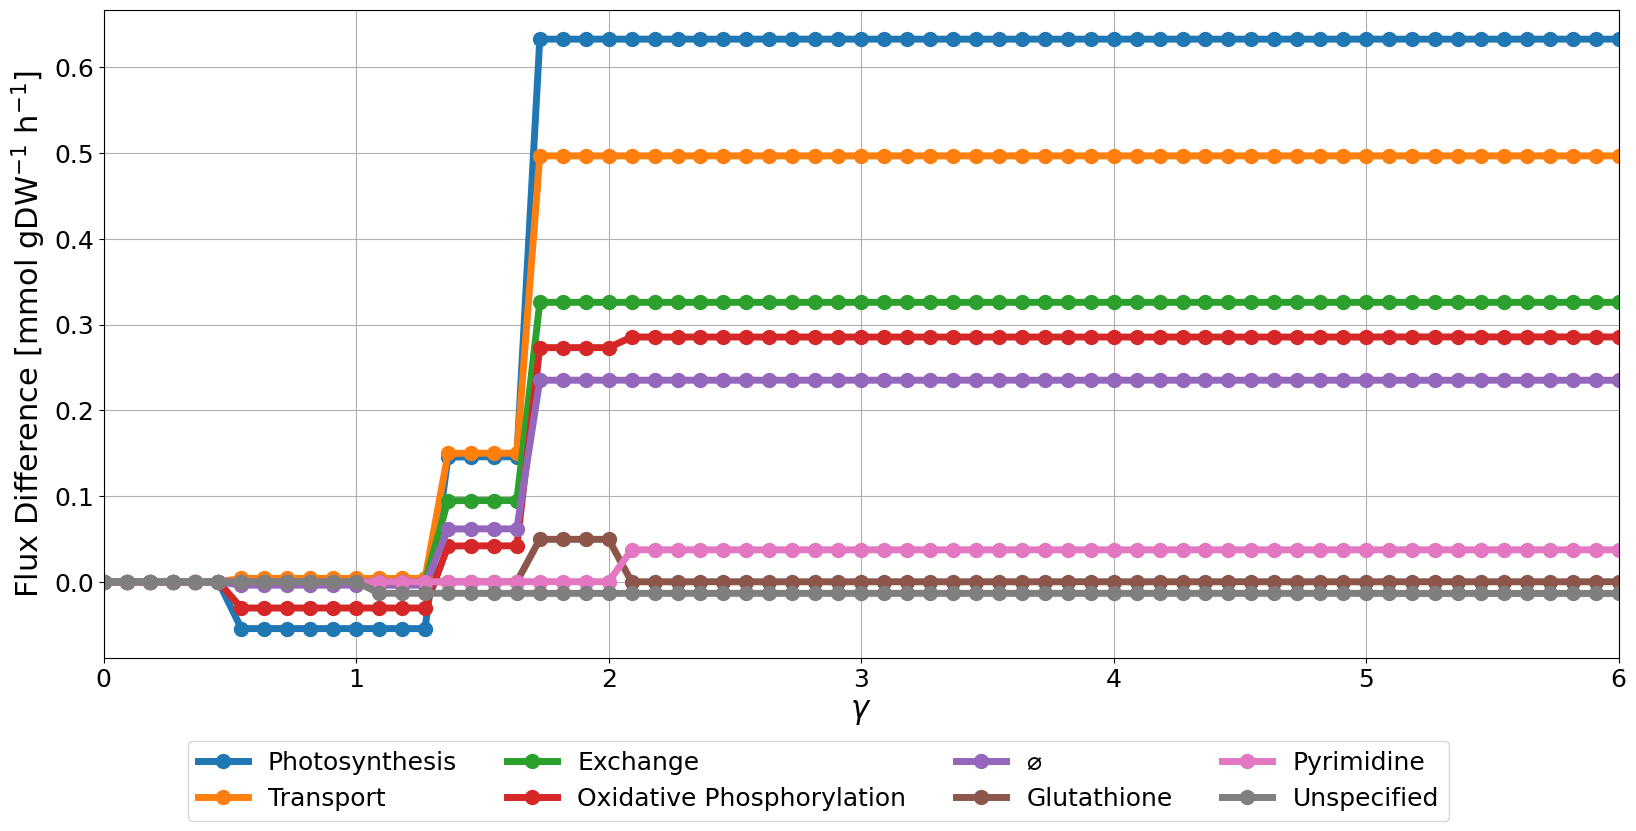

In [13]:
sys_diffs_in = {}
for factor in penalties:
    g_infected = gu.subsystem_flux_graph(
        model,
        flux_at_val(infecteds, factor),
        masses=no_mass_masses,
    )
    g_healthy = gu.subsystem_flux_graph(
        model,
        flux_at_val(baselines, factor),
        masses=no_mass_masses,
    )
    g_diff = gu.diff_graph(g_infected, g_healthy)
    if "AMG Emphasis Factor" in sys_diffs_in:
        sys_diffs_in["AMG Emphasis Factor"].append(factor)
    else:
        sys_diffs_in["AMG Emphasis Factor"] = [factor]
    for u in g_diff.nodes():
        deg = g_diff.out_degree(u, weight="weight")
        if u in sys_diffs_in:
            sys_diffs_in[u].append(deg / 1000)
        else:
            sys_diffs_in[u] = [deg / 1000]

sys_diffs_in = pd.DataFrame(sys_diffs_in)
sys_diffs_in.columns = [manual_relabels.get(u, u) for u in sys_diffs_in.columns]
sys_diffs_in.index = sys_diffs_in["AMG Emphasis Factor"]
sys_diffs_in = sys_diffs_in.drop("AMG Emphasis Factor", axis=1)
fig, ax = plt.subplots(1, 1, figsize=(17, 8), sharex=True)
top8sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[0:8].index
top10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[0:10].index
next10sys = sys_diffs_in.abs().max(axis=0).sort_values(ascending=False)[10:20].index
sys_diffs_in[top8sys].plot(
    ax=ax,
    marker="o",
    # fillstyle="none",
    linewidth=5,
    markersize=10,
    legend=False,
)
ax.tick_params(labelsize=18)
fig.legend(ncols=4, loc="upper center", bbox_to_anchor=(0.5, 0.05), fontsize=18)
ax.set_xlim(0, 6)
ax.set_xlabel("$\\gamma$", fontsize=22)
ax.set_ylabel(
    r"Flux Difference [mmol gDW$^{-1}$ h$^{-1}$]",
    fontsize=22,
)
ax.grid(True, which="both")

fig.tight_layout(pad=3.0)
plt.show()

In [14]:
sys_h = {}
sys_i = {}
for factor in penalties:
    g_infected = gu.subsystem_flux_graph(
        model,
        flux_at_val(infecteds, factor),
        masses=masses,
    )
    g_healthy = gu.subsystem_flux_graph(
        model,
        flux_at_val(baselines, factor),
        masses=masses,
    )

    if "AMG Emphasis Factor" in sys_i:
        sys_i["AMG Emphasis Factor"].append(factor)
    else:
        sys_i["AMG Emphasis Factor"] = [factor]

    if "AMG Emphasis Factor" in sys_h:
        sys_h["AMG Emphasis Factor"].append(factor)
    else:
        sys_h["AMG Emphasis Factor"] = [factor]

    for u in g_infected.nodes():
        deg = g_infected.in_degree(u, weight="weight")
        if u in sys_i:
            sys_i[u].append(deg / 1000)
        else:
            sys_i[u] = [deg / 1000]

    for u in g_healthy.nodes():
        deg = g_healthy.in_degree(u, weight="weight")
        if u in sys_h:
            sys_h[u].append(deg / 1000)
        else:
            sys_h[u] = [deg / 1000]

sys_i = pd.DataFrame(sys_i)
sys_i.columns = [manual_relabels.get(u, u) for u in sys_i.columns]

sys_h = pd.DataFrame(sys_h)
sys_h.columns = [manual_relabels.get(u, u) for u in sys_h.columns]

In [67]:
print(
    sys_i.iloc[23]["AMG Emphasis Factor"],
    sys_h.iloc[23]["Pyrimidine"],
    sys_i.iloc[23]["Pyrimidine"],
    sys_i.iloc[23]["Pyrimidine"] - sys_h.iloc[23]["Pyrimidine"],
)

2.090909090909091 0.08346380091483518 12.894789265691006 12.811325464776171


In [16]:
for sys in sys_i.columns:
    if sys == "AMG Emphasis Factor":
        continue
    print(
        f"{sys_i[sys].max():.3f}, {sys_h[sys].max():.3f}, {sys_i[sys].max() - sys_h[sys].max():.2f}, {sys}"
    )

0.001, 0.001, -0.00, Fake Transport Reaction
5.335, 5.335, 0.00, Unspecified
0.441, 0.441, -0.00, Pyruvate
0.007, 0.007, -0.00, C5-Branched dibasic acid metabolism
0.179, 0.179, 0.00, Pentose Phosphate
0.060, 0.060, -0.00, Glycerolipids
0.126, 0.126, 0.00, Glycine / Serine / Threonine
0.002, 0.002, -0.00, Peptidoglycan biosynthesis
0.002, 0.002, -0.00, D-Glutamine and D-glutamate metabolism
0.004, 0.004, -0.00, Galactose metabolism
13.073, 0.074, 13.00, Glutathione
0.000, 0.000, 0.00, Fructose and mannose metabolism
0.015, 0.015, -0.00, Histidine
0.068, 0.068, 0.00, Cysteine / Methionine
0.000, 0.000, 0.00, Ubiquinone and other terpenoid-quinone biosynthesis
3.322, 3.322, 0.00, Biomass
44.265, 5.725, 38.54, Oxidative Phosphorylation
0.080, 0.080, 0.00, Terpenoid Backbone
0.001, 0.001, -0.00, Riboflavin metabolism
0.000, 0.000, 0.00, Thiamine
6.116, 3.660, 2.46, Glycolysis / Gluconeogenesis
0.043, 0.043, 0.00, Alanine / Aspartate / Glutamate
2.964, 2.964, 0.00, Carbon fixation
0.001, 0.